### Importing Libraries


In [1]:
import requests
import json
import sys
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import numpy as np
import math

import time
from tqdm import tqdm

from google.cloud import bigquery
from google.oauth2 import service_account

from transformers import AutoModelForMaskedLM
from transformers import AutoModel, AutoConfig, AutoTokenizer, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup, DataCollatorWithPadding

import torch
from torch.profiler import profile, record_function, ProfilerActivity
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import warnings

warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Define configuration constants

In [2]:
class CFG:
    CPC_CODES_PATH = "../input/cpc-code-upto-subclass/CPC_codes_upto_subclass.csv"
    BERT_FOR_PATENTS_PATH = "../input/bert-for-patents/bert-for-patents-pytorch"
    DEBERTA_V3_LARGE_PATH = "../input/deberta-v3-large/deberta-v3-large"
    CPC_CODES_NUM_PATENTS_PATH = "../input/cpc-code-num-patents/cpc_code_num_patents.csv"
    MAX_TOKEN_LEN = 512
    DROPOUT_PROB = 0.2
    ATTENTION_INTERMEDIATE_SIZE = 512
    GOOGLE_CLOUD_CRED_JSON = '../input/googlecloudcred/us-patent-classification-d344a6ddc702.json'
    GOOGLE_CLOUD_PROJ_ID = 'us-patent-classification'
    BATCH_SIZE = 8
    NUM_EPOCHS = 5
    TRAIN_PATENT_START_YEAR = 2001
    TRAIN_PATENT_END_YEAR = 2018
    TEST_PATENT_START_YEAR = 2019
    TEST_PATENT_END_YEAR = 2022
    NUM_FOLDS = 6 #Total number of years used for training should be divisible by this number
    ENCODER_LR = 2e-5
    DECODER_LR = 2e-5
    MIN_LR = 1e-6
    EPS = 1e-6
    WEIGHT_DECAY = 0.01
    SCHEDULER = 'linear'
    NUM_WARMUP_STEPS = 0
    NUM_CYCLES = 0.5
    BETAS=(0.9, 0.999)
    MAX_GRAD_NORM = 1000
    PRINT_FREQ = 5
    INFINITY = 1e6
    F_TRAIN = 1
    
    # Parameters which will be added in subsequent code:
    # NUM_CLASSES, TRAIN_NUM_PATENTS

### List of CPC codes

In [3]:
cpc_codes_upto_subclass_df = pd.read_csv(CFG.CPC_CODES_PATH)
cpc_codes_upto_subclass_df.head()
num_codes = len(pd.unique(cpc_codes_upto_subclass_df['code']))
df_len = len(cpc_codes_upto_subclass_df)
CFG.NUM_CLASSES = df_len
print("Number of rows in dataframe: ", df_len, "\n")
print("Number of CPC codes upto subclass: ", num_codes)
cpc_code_dict = dict(zip(cpc_codes_upto_subclass_df['code'].values, cpc_codes_upto_subclass_df.index))

Number of rows in dataframe:  674 

Number of CPC codes upto subclass:  674


In [4]:
list(cpc_code_dict.keys())[:1]

['A01B']

### Accessing Google Cloud BigQuery Public Patent Data

In [5]:
credentials = service_account.Credentials.from_service_account_file(CFG.GOOGLE_CLOUD_CRED_JSON)

project_id = CFG.GOOGLE_CLOUD_PROJ_ID
bq_client = bigquery.Client(credentials= credentials, project = project_id)

In [6]:
'''

start_time = time.time()
    
cpc_code = cpc_codes_upto_subclass_df.iloc[1]['code']

query1 = r"""
SELECT DISTINCT t1.id, t2.group_id, t1.abstract
FROM `patents-public-data.patentsview.patent` t1, `patents-public-data.patentsview.cpc_current` t2 
WHERE t1.id = t2.patent_id AND t1.type='utility' AND timestamp(t1.date) >= timestamp('2000-01-01') AND timestamp(t1.date) <= timestamp('2018-12-31')
ORDER BY t1.id ASC, t2.group_id
LIMIT 64
OFFSET 0
"""

query2 = r"""
SELECT COUNT(CPCCode) AS num_patents
FROM(
SELECT DISTINCT t1.id AS PatentID, t2.group_id AS CPCCode
FROM `patents-public-data.patentsview.patent` t1,
`patents-public-data.patentsview.cpc_current` t2 where t1.id = t2.patent_id
and t1.type='utility'
and t2.group_id = '{}'
and timestamp(t1.date) >= timestamp('2000-01-01')
)
""".format(cpc_code)


df1 = bq_client.query(query1).to_dataframe()
#df2 = bq_client.query(query2).to_dataframe()

    
end_time = time.time()

print("Time taken: ", end_time - start_time, " seconds")

df_curr = df1.loc[df1['id'] == df1['id'].unique()[1]]
label_list = []
label_list.append(list(df_curr['group_id']))
label_list

'''

'\n\nstart_time = time.time()\n    \ncpc_code = cpc_codes_upto_subclass_df.iloc[1][\'code\']\n\nquery1 = r"""\nSELECT DISTINCT t1.id, t2.group_id, t1.abstract\nFROM `patents-public-data.patentsview.patent` t1, `patents-public-data.patentsview.cpc_current` t2 \nWHERE t1.id = t2.patent_id AND t1.type=\'utility\' AND timestamp(t1.date) >= timestamp(\'2000-01-01\') AND timestamp(t1.date) <= timestamp(\'2018-12-31\')\nORDER BY t1.id ASC, t2.group_id\nLIMIT 64\nOFFSET 0\n"""\n\nquery2 = r"""\nSELECT COUNT(CPCCode) AS num_patents\nFROM(\nSELECT DISTINCT t1.id AS PatentID, t2.group_id AS CPCCode\nFROM `patents-public-data.patentsview.patent` t1,\n`patents-public-data.patentsview.cpc_current` t2 where t1.id = t2.patent_id\nand t1.type=\'utility\'\nand t2.group_id = \'{}\'\nand timestamp(t1.date) >= timestamp(\'2000-01-01\')\n)\n""".format(cpc_code)\n\n\ndf1 = bq_client.query(query1).to_dataframe()\n#df2 = bq_client.query(query2).to_dataframe()\n\n    \nend_time = time.time()\n\nprint("Time take

### Count the number of patents for each cpc_code

In [7]:
if os.path.exists(CFG.CPC_CODES_NUM_PATENTS_PATH):
    
    cpc_code_number_df = pd.read_csv(CFG.CPC_CODES_NUM_PATENTS_PATH)
    
else:

    cpc_code_number_df = pd.DataFrame() 

    for cpc_code in tqdm(list(cpc_code_dict.keys())):
        
        start_date = r'{}-01-01'.format(CFG.TRAIN_PATENT_START_YEAR)
        end_date = r'{}-12-31'.format(CFG.TRAIN_PATENT_END_YEAR)

        query = r"""
                 SELECT COUNT(CPCCode) AS num_patents
                 FROM(
                 SELECT DISTINCT t1.id AS PatentID, t2.group_id AS CPCCode
                 FROM `patents-public-data.patentsview.patent` t1,
                 `patents-public-data.patentsview.cpc_current` t2 where t1.id = t2.patent_id
                 and t1.type='utility'
                 and t2.group_id = '{}'
                 and timestamp(t1.date) >= timestamp('{}') and timestamp(t1.date) <= timestamp('{}')
                 )""".format(cpc_code, start_date, end_date)
        
        df = bq_client.query(query).to_dataframe()
        df.insert(loc = 0, column = 'cpc_code', value = cpc_code)

        cpc_code_number_df = cpc_code_number_df.append(df, ignore_index = True)


    cpc_code_number_df.to_csv('./cpc_code_num_patents.csv')

In [8]:
def find_num_dstnct_patent_cpc_in_years(start_year, end_year):
    
    start_date = r'{}-01-01'.format(start_year)
    end_date = r'{}-12-31'.format(end_year)
    
    query = r"""
                 SELECT COUNT(CPCCode) AS dstnct_patent_cpc
                 FROM(
                 SELECT DISTINCT t1.id AS PatentID, t2.group_id AS CPCCode
                 FROM `patents-public-data.patentsview.patent` t1,
                 `patents-public-data.patentsview.cpc_current` t2 where t1.id = t2.patent_id
                 and t1.type='utility'
                 and timestamp(t1.date) >= timestamp('{}') and timestamp(t1.date) <= timestamp('{}')
                 )""".format(start_date, end_date)
    
    df = bq_client.query(query).to_dataframe()
    return df['dstnct_patent_cpc'][0]

In [9]:
m = find_num_dstnct_patent_cpc_in_years(2001, 2018)
m

7970125

In [10]:
def find_num_patents_in_years(start_year, end_year):
    
    start_date = r'{}-01-01'.format(start_year)
    end_date = r'{}-12-31'.format(end_year)
    
    query = r""" SELECT COUNT(PatentID) AS total_num_patents
                 FROM(
                 SELECT DISTINCT t1.id as PatentID
                 FROM `patents-public-data.patentsview.patent` t1
                 where t1.type='utility'
                 and timestamp(t1.date) >= timestamp('{}') and timestamp(t1.date) <= timestamp('{}')
                 )""".format(start_date, end_date)
    
    df = bq_client.query(query).to_dataframe()
    return df['total_num_patents'][0]

In [11]:
n = find_num_patents_in_years(2003, 2003)
n

169077

Total number of patents:  7970118


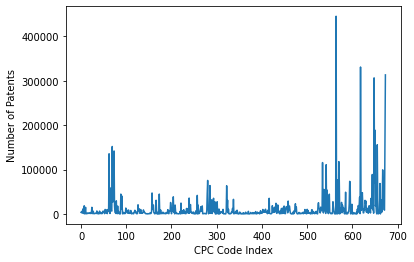

In [12]:
plt.plot(cpc_code_number_df.index, cpc_code_number_df['num_patents'])
plt.xlabel('CPC Code Index')
plt.ylabel('Number of Patents')

print("Total number of patents: ", cpc_code_number_df['num_patents'].sum())
CFG.TRAIN_NUM_PATENTS = cpc_code_number_df['num_patents'].sum()

In [13]:
CFG.TRAIN_NUM_PATENTS

7970118

### Calculate weights to handle class imbalance

In [14]:
cpc_code_number_df['weights'] = cpc_code_number_df['num_patents'].sum()/cpc_code_number_df['num_patents']
cpc_code_number_df['weights'].replace(np.inf, 0.0, inplace = True)
cpc_code_number_df['weights'] = cpc_code_number_df['weights']/cpc_code_number_df['weights'].sum()

### Run a sample input through the BERT for Patents model

In [15]:
model_bert_for_patents = AutoModel.from_pretrained(CFG.BERT_FOR_PATENTS_PATH)

tokenizer = AutoTokenizer.from_pretrained(CFG.BERT_FOR_PATENTS_PATH)
CFG.tokenizer = tokenizer

config = AutoConfig.from_pretrained(CFG.BERT_FOR_PATENTS_PATH)
sent = "This is a patent."
tokenized_sent = tokenizer(sent, padding = True, truncation = True, return_tensors = "pt")
print(tokenized_sent)
out = model_bert_for_patents(**tokenized_sent)


Some weights of the model checkpoint at ../input/bert-for-patents/bert-for-patents-pytorch were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no pr

{'input_ids': tensor([[   2, 1688, 1668, 1042, 7018, 1017,    3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [16]:
config

BertConfig {
  "_name_or_path": "../input/bert-for-patents/bert-for-patents-pytorch",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 39859
}

In [17]:
print(out.last_hidden_state.shape)

torch.Size([1, 7, 1024])


### Run a sample input through DEBERTA V3 LARGE model

In [18]:
config = AutoConfig.from_pretrained(CFG.DEBERTA_V3_LARGE_PATH, output_hidden_states = True)
model_deberta_v3_large = AutoModel.from_pretrained(CFG.DEBERTA_V3_LARGE_PATH, config = config)
tokenizer = AutoTokenizer.from_pretrained(CFG.DEBERTA_V3_LARGE_PATH)

sent = "This is a patent."
tokenized_sent = tokenizer(sent, padding = True, truncation = True, return_tensors = "pt")
print(tokenized_sent)
out = model_deberta_v3_large(**tokenized_sent)


Some weights of the model checkpoint at ../input/deberta-v3-large/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifer.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifer.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Specia

{'input_ids': tensor([[   1,  329,  269,  266, 6581,  260,    2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [19]:
print(out[0])

tensor([[[-0.4624, -0.1580,  0.1821,  ..., -0.0218, -5.3449,  0.0437],
         [-0.3222,  0.1772, -0.6142,  ...,  0.7221, -0.6977,  0.3440],
         [ 0.0907,  0.5733, -0.2337,  ...,  0.7742, -0.7838,  0.4246],
         ...,
         [ 0.0646, -0.6353,  0.1548,  ...,  1.3551, -0.1917,  1.0668],
         [-0.1836,  0.2148,  0.4133,  ...,  0.6328,  0.4898,  0.6443],
         [ 1.5244, -0.5936,  0.5181,  ..., -0.0644,  0.2917,  0.0191]]],
       grad_fn=<NativeLayerNormBackward0>)


### Build Custom Dataset

In [20]:
class PatentClassification_TrainDataset(IterableDataset):
    def __init__(self, cfg, cpc_code_dict, data_year_ranges, num_batches):
        '''
        data_year_ranges can be 1x2 list or 2x2 list
        every row of the list specifies an year range
        '''
        super(PatentClassification_TrainDataset).__init__()
        self.cfg = cfg
        self.cpc_code_dict = cpc_code_dict
        credentials = service_account.Credentials.from_service_account_file(self.cfg.GOOGLE_CLOUD_CRED_JSON)
        self.bq_client = bigquery.Client(credentials= credentials, project = self.cfg.GOOGLE_CLOUD_PROJ_ID)
        self.table_row_offset = 0
        self.text = []
        self.label_lists = []
        self.num_batches = num_batches
        if len(data_year_ranges) == 1:
            self.data_start_date1 = r'{}-01-01'.format(data_year_ranges[0][0])
            self.data_end_date1 = r'{}-12-31'.format(data_year_ranges[0][1])
            self.data_start_date2 = self.data_start_date1
            self.data_end_date2 = self.data_end_date1
        else:
            self.data_start_date1 = r'{}-01-01'.format(data_year_ranges[0][0])
            self.data_end_date1 = r'{}-12-31'.format(data_year_ranges[0][1])
            self.data_start_date2 = r'{}-01-01'.format(data_year_ranges[1][0])
            self.data_end_date2 = r'{}-12-31'.format(data_year_ranges[1][1])
        
        if self.data_start_date1 != self.data_start_date2:
            self.num_table_rows = find_num_dstnct_patent_cpc_in_years(data_year_ranges[0][0], data_year_ranges[0][1]) + \
                                  find_num_dstnct_patent_cpc_in_years(data_year_ranges[1][0], data_year_ranges[1][1])
        else:
            self.num_table_rows = find_num_dstnct_patent_cpc_in_years(data_year_ranges[0][0], data_year_ranges[0][1])
            
        self.f_reach_end = 0
        
        
    def prepare_input(self):
        inputs = self.cfg.tokenizer(self.text, add_special_tokens=True, max_length=self.cfg.MAX_TOKEN_LEN, padding="max_length",
                               return_offsets_mapping=False)
        for k, v in inputs.items():
            inputs[k] = torch.tensor(v, dtype=torch.long)
            
        labels = torch.zeros(len(self.label_lists), self.cfg.NUM_CLASSES, dtype = torch.float)
        
        for i, label_list in enumerate(self.label_lists):
            indices = torch.tensor(list(map(self.cpc_code_dict.__getitem__, label_list)))
            labels[i].index_fill_(0, indices, 1.0)         
            
        return inputs, labels
            
                  
    def __iter__(self):
        
        if self.data_start_date1 != self.data_start_date2:
            query = r"""
                    SELECT DISTINCT t1.id, t2.group_id, t1.abstract
                    FROM `patents-public-data.patentsview.patent` t1, `patents-public-data.patentsview.cpc_current` t2 
                    WHERE t1.id = t2.patent_id AND t1.type='utility' AND ((timestamp(t1.date) >= timestamp('{}') AND timestamp(t1.date) <= timestamp('{}'))
                    OR (timestamp(t1.date) >= timestamp('{}') AND timestamp(t1.date) <= timestamp('{}')))
                    ORDER BY t1.id ASC, t2.group_id
                    LIMIT {}
                    OFFSET {}
                    """.format(self.data_start_date1, self.data_end_date1, self.data_start_date2, self.data_end_date2, 
                               self.cfg.BATCH_SIZE, self.table_row_offset)
        else:
            query = r"""
                    SELECT DISTINCT t1.id, t2.group_id, t1.abstract
                    FROM `patents-public-data.patentsview.patent` t1, `patents-public-data.patentsview.cpc_current` t2 
                    WHERE t1.id = t2.patent_id AND t1.type='utility' AND timestamp(t1.date) >= timestamp('{}') AND timestamp(t1.date) <= timestamp('{}')
                    ORDER BY t1.id ASC, t2.group_id
                    LIMIT {}
                    OFFSET {}
                    """.format(self.data_start_date1, self.data_end_date1, self.cfg.BATCH_SIZE, self.table_row_offset)
            
        
        df = self.bq_client.query(query).to_dataframe()
        patent_ids = df['id'].unique()
        for patent_id in patent_ids:
            df_curr = df.loc[df['id'] == patent_id].reset_index()
            self.text.append(df_curr['abstract'][0]) #since patent id is same, abstracts are same(basically same patent has multiple cpc codes)
            self.label_lists.append(list(df_curr['group_id']))
            
        inputs, labels = self.prepare_input()
        
        self.table_row_offset  = self.table_row_offset + self.cfg.BATCH_SIZE
        if self.table_row_offset >= self.num_table_rows:
            self.table_row_offset = 0  #most probably not needed
            self.f_reach_end = 1
            
        self.text = []
        self.label_lists = []
        
        yield inputs, labels, self.f_reach_end
        
        
def worker_init_fn(_):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset  # the dataset copy in this worker process
    num_batches_per_worker = dataset.num_batches//worker_info.num_workers
    worker_id = worker_info.id
    dataset.table_row_offset = worker_id*num_batches_per_worker*dataset.cfg.BATCH_SIZE
   

In [21]:
data_year_ranges = [[2000, 2005]]
num_batches = math.ceil(find_num_patents_in_years(data_year_ranges[0][0], data_year_ranges[0][1])/ CFG.BATCH_SIZE)

train_dataset = PatentClassification_TrainDataset(CFG, cpc_code_dict, [[2000, 2005]], num_batches)
train_dataloader = DataLoader(train_dataset, batch_size = None, num_workers = 4, worker_init_fn = worker_init_fn)

for _ in range(1):
    inputs, labels, f_reached_end = next(iter(train_dataloader))
    

### Build Custom Model

In [22]:
class PatentClassificationModel(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.model_config = AutoConfig.from_pretrained(self.cfg.BERT_FOR_PATENTS_PATH, output_hidden_states=True)
        self.model = AutoModel.from_pretrained(self.cfg.BERT_FOR_PATENTS_PATH, config = self.model_config) 
        self.attention = torch.nn.Sequential(torch.nn.Linear(self.model_config.hidden_size, self.cfg.ATTENTION_INTERMEDIATE_SIZE),
                                             torch.nn.Tanh(),
                                             torch.nn.Linear(self.cfg.ATTENTION_INTERMEDIATE_SIZE, 1),
                                            torch.nn.Softmax(dim=1))
        self.fc_dropout = torch.nn.Dropout(self.cfg.DROPOUT_PROB)
        self.fc = torch.nn.Linear(self.model_config.hidden_size, self.cfg.NUM_CLASSES)
        
        
    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, torch.nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, torch.nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, inputs):
        #one abstract can have multiple cpc codes, hence pass a list of cpc codes for each abstract
        model_outputs = self.model(**inputs)
        last_hidden_states = model_outputs.last_hidden_state
        weights = self.attention(last_hidden_states)
        weighted_avg_hidden_states = torch.sum(weights * last_hidden_states, dim=1)
        outputs = self.fc(self.fc_dropout(weighted_avg_hidden_states))
        return outputs
        

In [23]:
model = PatentClassificationModel(CFG)

Some weights of the model checkpoint at ../input/bert-for-patents/bert-for-patents-pytorch were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Helper functions

In [24]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters


    
# ====================================================
# scheduler
# ====================================================
def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.SCHEDULER == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS, num_training_steps=num_train_steps
        )
    elif cfg.SCHEDULER == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS, num_training_steps=num_train_steps, num_cycles=cfg.NUM_CYCLES
        )
    return scheduler


# ====================================================
# Function to calculate loss
# ====================================================
def get_loss(preds, labels, criterion):
    with torch.autocast(device_type = device.type):
        loss = criterion(preds.view(-1, 1), labels.view(-1, 1))  
        loss = loss.item()
    return loss
    

def train_fn(train_dataloader, num_batches, model, criterion, optimizer, epoch, scheduler, device):
    
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    loss_info = AverageMeter()
    f_end_reached = 0
    step_num = 0
    start = end = time.time()
    
    while not f_end_reached:
        
        step_num = step_num + 1
        inputs, labels, f_end_reached = next(iter(train_dataloader))
        
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        
        batch_size = labels.size(0)
        
        with torch.autocast(device_type = device.type):
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 1), labels.view(-1, 1))
            
        loss_info.update(loss.item(), batch_size)
                
        # Set all gradients to 0
        optimizer.zero_grad()
        
        # Calculate and scale gradients
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.MAX_GRAD_NORM)
        
        # Update Weights and Biases, Scaler
        scaler.step(optimizer)
        scaler.update()
        
        #Update Scheduler
        scheduler.step()
        
        if step_num % CFG.PRINT_FREQ == 0 or step_num == num_batches - 1:
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step_num, num_batches, 
                          remain=timeSince(start, float(step_num)/num_batches),
                          loss=loss_info,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    
    return loss_info.avg

def valid_fn(valid_dataloader, num_batches, model, criterion, device):
    
    model.eval()
    loss_info = AverageMeter()
    f_end_reached = 0
    step_num = 0
    start = end = time.time()
    
    while not f_end_reached:
        
        step_num = step_num + 1
        inputs, labels, f_end_reached = next(iter(valid_dataloader))
        
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        
        batch_size = labels.size(0)
        
        with torch.autocast(device_type = device.type):
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs.view(-1, 1), labels.view(-1, 1))      
                    
        loss_info.update(loss.item(), batch_size)
        try:
            preds_concat = torch.cat((preds_concat, outputs), dim = 0)
            labels_concat = torch.cat((labels_concat, labels), dim = 0)
        except:    
            preds_concat = outputs
            labels_concat = labels
        
        if step_num % CFG.PRINT_FREQ == 0 or step_num == num_batches - 1:
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(epoch+1, step_num, num_batches, 
                          remain=timeSince(start, float(step_num)/num_batches),
                          loss=loss_info))
        
        
        return loss_info.avg, preds_concat, labels_concat
    
    

                    
 

### Training loop

In [25]:
def train_loop(fold):
    
    train_year_ranges = [[0, 0], [0, 0]]
    valid_year_range = [[0, 0]]
    fold_year_range_len = (CFG.TRAIN_PATENT_END_YEAR - (CFG.TRAIN_PATENT_START_YEAR - 1))/CFG.NUM_FOLDS
    valid_year_range[0][0] = int(CFG.TRAIN_PATENT_START_YEAR + (fold - 1)*fold_year_range_len)
    valid_year_range[0][1] = int(valid_year_range[0][0] + (fold_year_range_len - 1))
    if fold == 1:
        train_year_ranges[0][0] = int(valid_year_range[0][1] + 1)
        train_year_ranges[0][1] = int(CFG.TRAIN_PATENT_END_YEAR)
        train_year_ranges[1][0] = train_year_ranges[0][0] 
        train_year_ranges[1][1] = train_year_ranges[0][1]    
    else:
        train_year_ranges[0][0] = int(CFG.TRAIN_PATENT_START_YEAR)
        train_year_ranges[0][1] = int(valid_year_range[0][0] - 1)
        train_year_ranges[1][0] = int(valid_year_range[0][1] + 1)
        train_year_ranges[1][1] = int(CFG.TRAIN_PATENT_END_YEAR)

    
    model = PatentClassificationModel(CFG)
    model.to(device)
    
    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.ENCODER_LR, 
                                                decoder_lr=CFG.DECODER_LR,
                                                weight_decay=CFG.WEIGHT_DECAY)
    
    optimizer = AdamW(optimizer_parameters, lr=CFG.ENCODER_LR, eps=CFG.EPS, betas=CFG.BETAS)
    if fold == 1:
        num_train_batches = math.ceil(find_num_patents_in_years(train_year_ranges[0][0], train_year_ranges[0][1])/ CFG.BATCH_SIZE)
    else:
        num_train_batches = math.ceil((find_num_patents_in_years(train_year_ranges[0][0], train_year_ranges[0][1]) + \
                                 find_num_patents_in_years(train_year_ranges[1][0], train_year_ranges[1][1]))/ CFG.BATCH_SIZE)
    num_val_batches = math.ceil(find_num_patents_in_years(valid_year_range[0][0], valid_year_range[0][1])/ CFG.BATCH_SIZE)
        
    
    num_train_steps = num_batches * CFG.NUM_EPOCHS
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)
    
    # ====================================================
    # loop
    # ====================================================
    criterion = torch.nn.BCEWithLogitsLoss(reduction="mean")
    
    best_loss = CFG.INFINITY
    best_epoch = 0
    
    train_dataset = PatentClassification_TrainDataset(CFG, cpc_code_dict, train_year_ranges, num_train_batches)
    valid_dataset = PatentClassification_TrainDataset(CFG, cpc_code_dict, valid_year_range, num_val_batches)
    
    #num_workers = 2 gives best speed (for GPU)
    train_dataloader = DataLoader(train_dataset, batch_size = None, num_workers = 2, worker_init_fn = worker_init_fn) #batches are created in dataset itself
    valid_dataloader = DataLoader(valid_dataset, batch_size = None, num_workers = 2, worker_init_fn = worker_init_fn) #batches are created in dataset itself
    
    
    for epoch in range(CFG.NUM_EPOCHS):
        start_time = time.time()
        
        #train
        avg_train_loss = train_fn(train_dataloader, num_train_batches, model, criterion, optimizer, epoch, scheduler, device)
        
        #eval
        avg_val_loss, preds_val, labels_val = valid_fn(valid_dataloader, num_val_batches, model, criterion, device)
        
        #overall validation loss
        overall_val_loss = get_loss(preds_concat, labels_concat, criterion)
        
        elapsed = time.time() - start_time
        
        print(f"Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f},  avg_val_loss: {avg_val_loss:.4f},  overall_val_loss: {overall_val_loss: 4f} time: {elapsed:.0f}s")
            
        if overall_val_loss < best_loss:
            best_loss = overall_val_loss
            best_epoch = epoch + 1
            best_epoch_preds_val = preds_val
            best_epoch_labels_val = labels_val
            print(f'Epoch {best_epoch} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict()},
                       OUTPUT_DIR+f"model_fold{fold}_best.pth")
    
          
            
    torch.cuda.empty_cache()
    gc.collect()
              
    return best_epoch_preds_val, best_epoch_labels_val 

In [26]:
if __name__ == '__main__':
    
    if CFG.F_TRAIN:
        
        for fold in range(1, CFG.NUM_FOLDS, 1):
            best_epoch_preds_val, best_epoch_labels_val = train_loop(fold)
            
            if fold != 1:
                concat_preds_val = torch.cat((concat_preds_val, best_epoch_preds_val), dim = 0)
                concat_labels_val = torch.cat((concat_labels_val, best_epoch_labels_val), dim = 0)
            else:
                concat_preds_val = best_epoch_preds_val
                concat_labels_val = best_epoch_labels_val
                
            fold_val_loss = get_loss(best_epoch_preds_val, best_epoch_labels_val, criterion)
            print(f"Fold {fold} validation loss: {fold_val_loss:.4f}")
            
        overall_val_loss = get_loss(concat_preds_val, concat_labels_val, criterion)
        print(f"Overall Cross Validation loss: {overall_val_loss:.4f}")

Some weights of the model checkpoint at ../input/bert-for-patents/bert-for-patents-pytorch were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][5/20925] Elapsed 0m 20s (remain 1442m 23s) Loss: 0.6530(0.6781) Grad: 25437.0781  LR: 0.00002000  
Epoch: [1][10/20925] Elapsed 0m 34s (remain 1190m 23s) Loss: 0.5858(0.6459) Grad: 42732.9102  LR: 0.00002000  
Epoch: [1][15/20925] Elapsed 0m 46s (remain 1088m 51s) Loss: 0.5168(0.6120) Grad: 32012.1699  LR: 0.00002000  
Epoch: [1][20/20925] Elapsed 0m 59s (remain 1032m 25s) Loss: 0.4575(0.5798) Grad: 31056.2676  LR: 0.00002000  
Epoch: [1][25/20925] Elapsed 1m 11s (remain 996m 46s) Loss: 0.4162(0.5502) Grad: 27193.9805  LR: 0.00002000  
Epoch: [1][30/20925] Elapsed 1m 23s (remain 973m 33s) Loss: 0.3811(0.5239) Grad: 25830.4980  LR: 0.00002000  
Epoch: [1][35/20925] Elapsed 1m 35s (remain 953m 55s) Loss: 0.3540(0.5011) Grad: 23612.6582  LR: 0.00002000  


KeyboardInterrupt: 